<a href="https://colab.research.google.com/github/joelleslim/detection-project-on-panoramic-X-rays/blob/dental_rtg_test/FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

Loading the data

In [ ]:
images_dir ='/content/drive/MyDrive/detect_caries/images_cut'
masks_dir = '/content/drive/MyDrive/detect_caries/labels_cut'

In [ ]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Visualizing some random images of the dataset

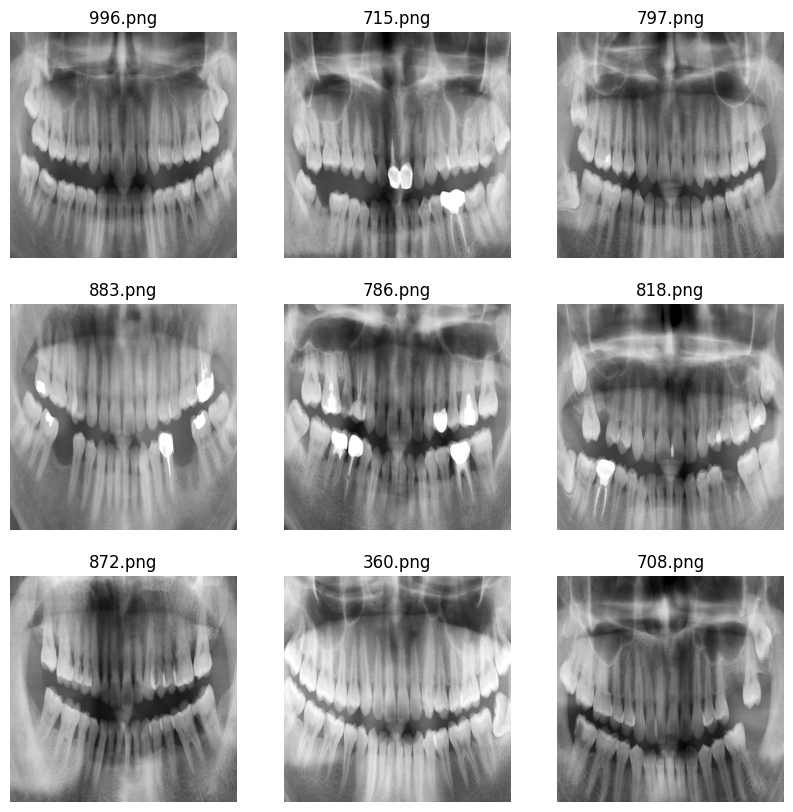

In [ ]:
rows = 3
cols = 3
image_size = 512
input_image_size=(512,512)
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

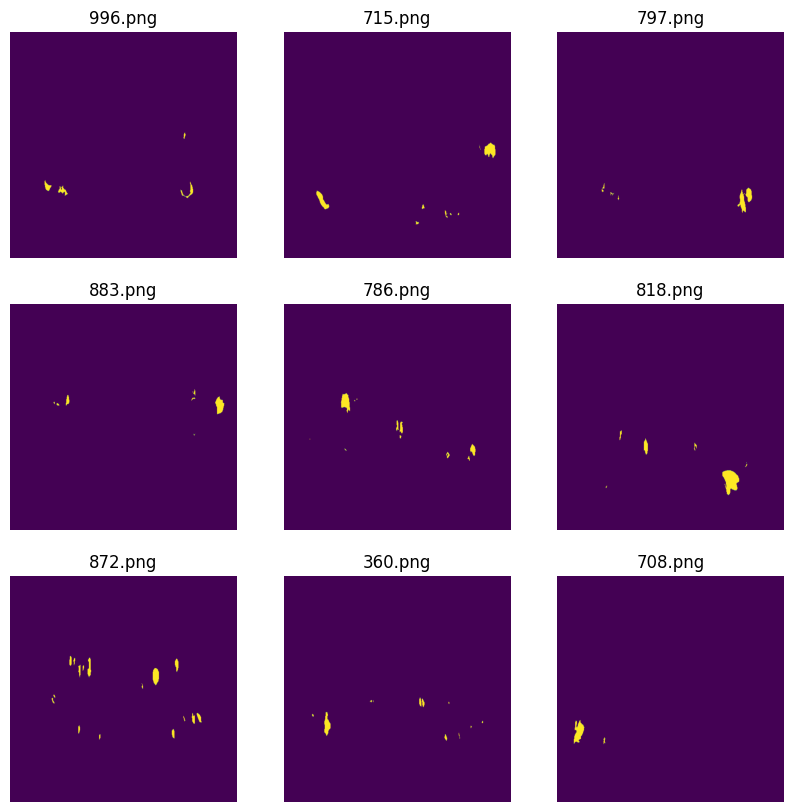

In [ ]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [ ]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

In [ ]:
number = 200
for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

Preparing formats of IMAGES and MASKS

In [ ]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


Spliting data into train and test data

In [ ]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [ ]:
print(len(images_train), len(masks_train))
print(len(images_test), len(masks_test))

60 60
40 40


Building The UNet

Downsampling:
Convolutional block containing a Double: 2D Convolution, Batch normalization and ReLu activation function

In [ ]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

Encoder block which contains the convolutional block and a max pooling layer

In [ ]:
def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

Upsampling
A decoder block for upsampling with Conv2DTranspose and Concatenate

In [ ]:
def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

Assembling everything
Assembling the Unet architecture, the downsampling phase and the upsampling phase, with a bridge between them.
The output layer is a 2D convolutional layer with sigmoid activation.

In [ ]:
def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training phase:

In [ ]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 10)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1705s 139s/step - accuracy: 0.5613 - loss: -1.7817 - val_accuracy: 0.0000e+00 - val_loss: -10808.6396
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1671s 137s/step - accuracy: 0.8533 - loss: -11.4317 - val_accuracy: 0.0000e+00 - val_loss: -2011787.0000
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1613s 135s/step - accuracy: 0.8792 - loss: -10.1942 - val_accuracy: 0.0000e+00 - val_loss: -24900.4512
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1598s 131s/step - accuracy: 0.8436 - loss: -15.4871 - val_accuracy: 0.0034 - val_loss: -252.2913
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1601s 135s/step - accuracy: 0.7288 - loss: -16.3122 - val_accuracy: 0.0011 - val_loss: -1504.7832
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1648s 135s/step - accuracy: 0.7949 - loss: -19.2900 - val_accuracy: 7.4482e-04 - val_loss: -4792.7896
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1607s 135s/step - accuracy: 0.6027 - loss: -23.6610 - val_accuracy: 4.0690e-05 - val_loss: -1194.3560
Epoch 8/10
12/12 ━━━━━━━━

Showing the result:

In [ ]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [ ]:
unet_predict = unet_model.predict(images_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 336s 64s/step


In [28]:
r1,r2,r3,r4=0.6,0.7,0.8,0.9

In [29]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

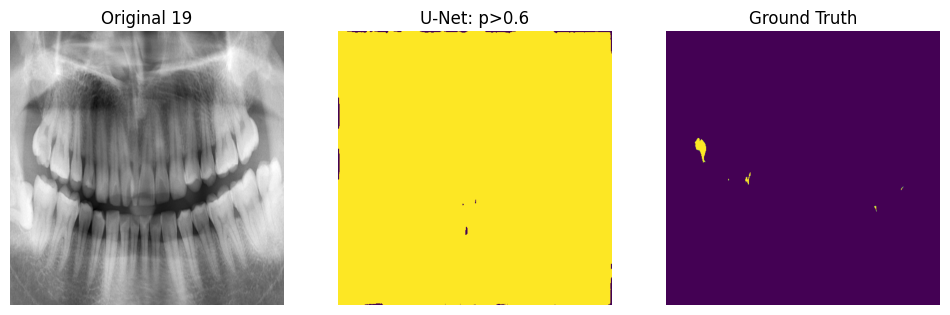

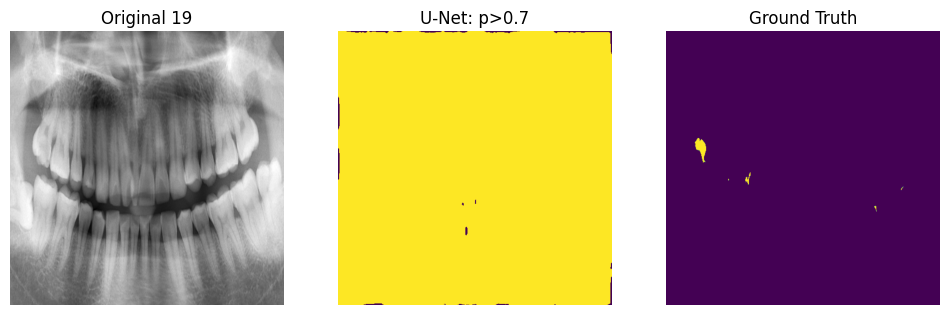

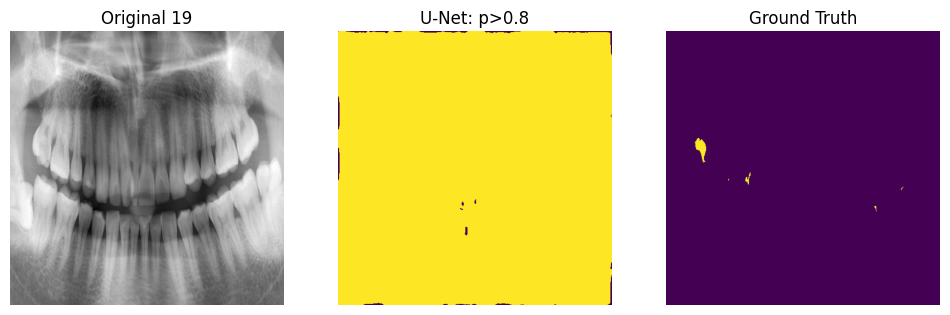

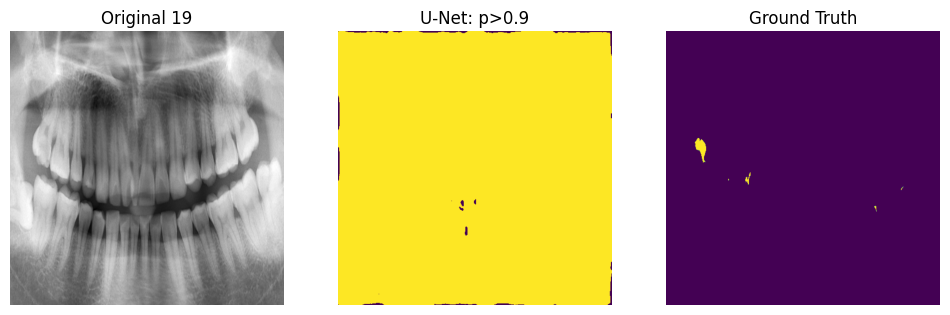

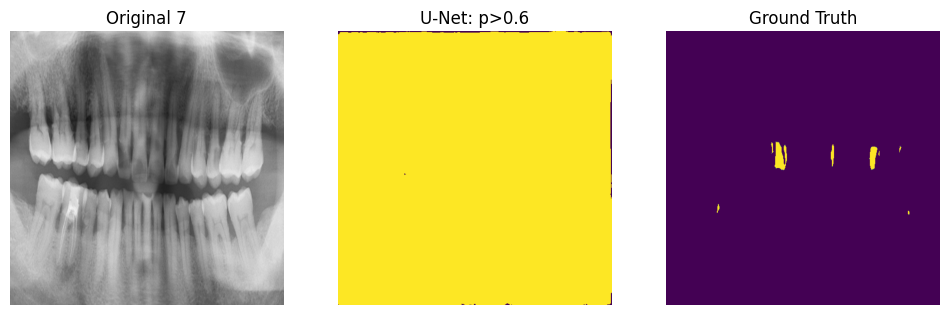

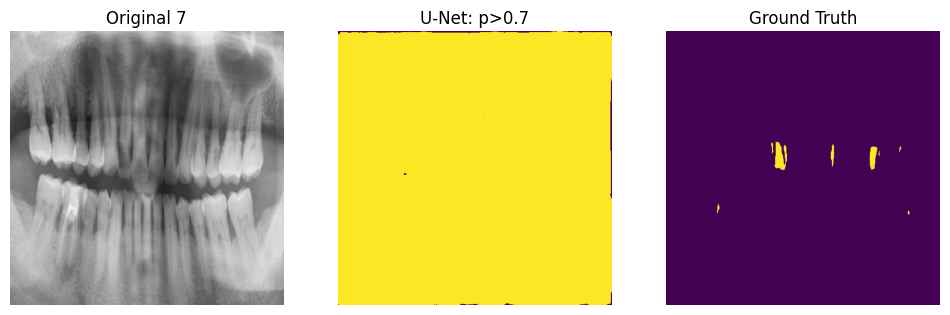

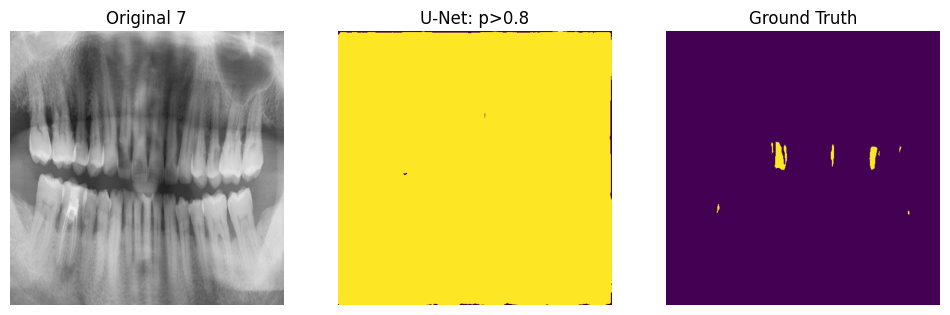

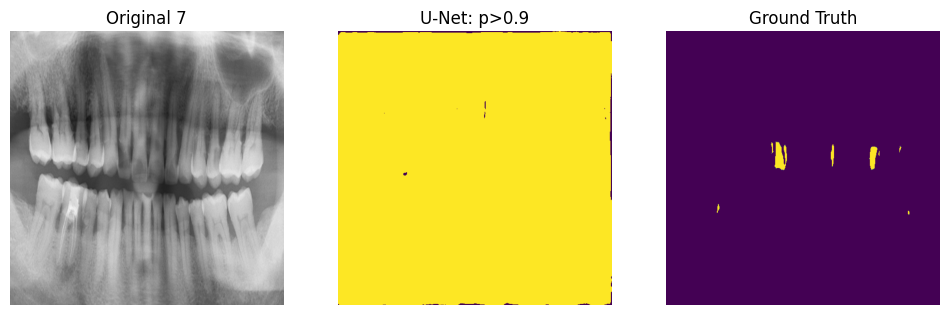

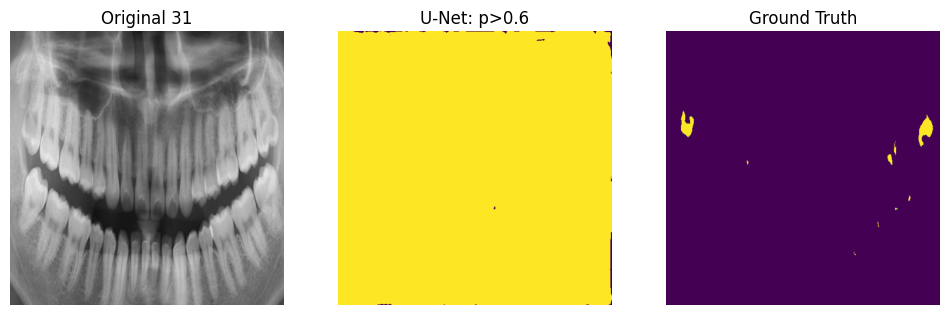

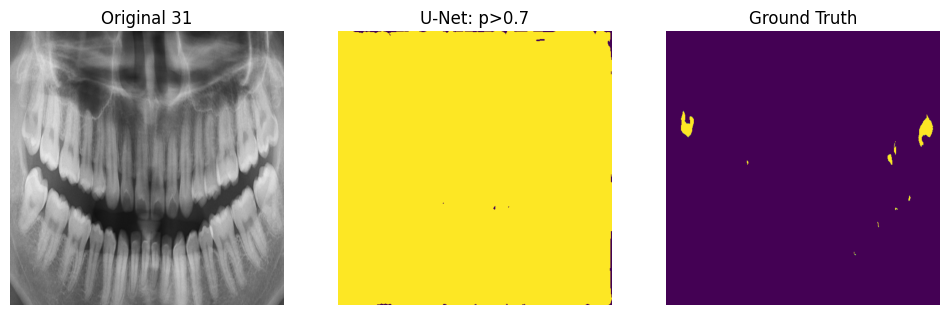

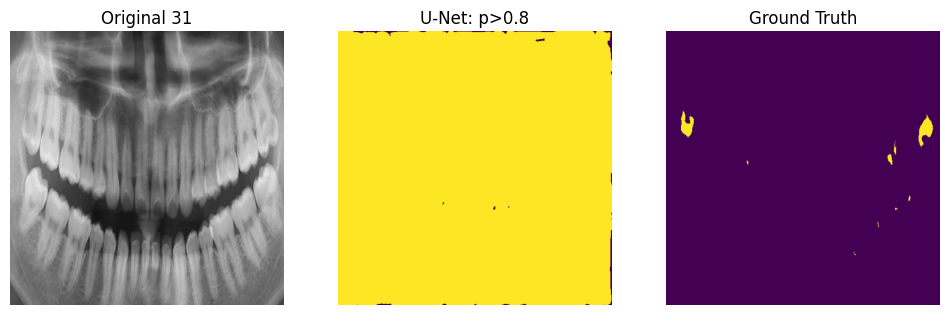

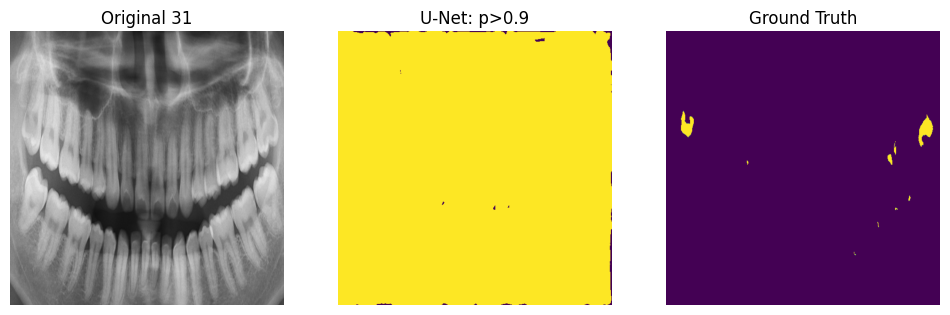

In [30]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

Calculating the

In [31]:
import numpy as np

def compute_metrics(pred_mask, true_mask):
    pred = pred_mask.flatten()
    true = true_mask.flatten()

    tp = np.sum((pred == 1) & (true == 1))
    tn = np.sum((pred == 0) & (true == 0))
    fp = np.sum((pred == 1) & (true == 0))
    fn = np.sum((pred == 0) & (true == 1))
    pixel_accuracy = (tp + tn) / (tp + tn + fp + fn)
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    return pixel_accuracy, iou, dice

In [33]:
pixel_accuracies = []
ious = []
dices = []
for idx in range(len(masks_test)):
    true_mask = masks_test[idx]

    for pred_mask in [unet_predict1[idx], unet_predict2[idx], unet_predict3[idx], unet_predict4[idx]]:
        pa, iou, dice = compute_metrics(pred_mask, true_mask)
        pixel_accuracies.append(pa)
        ious.append(iou)
        dices.append(dice)
avg_pixel_accuracy = np.mean(pixel_accuracies)
avg_iou = np.mean(ious)
avg_dice = np.mean(dices)

print(f"Average Pixel Accuracy: {avg_pixel_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Coefficient: {avg_dice:.4f}")

Average Pixel Accuracy: 0.0088
Average IoU: 0.0000
Average Dice Coefficient: 0.0000
